In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load Data

In [3]:
train_data = np.load('Sheep_Market/train.npy', encoding='bytes')
validation_data = np.load('Sheep_Market/valid.npy', encoding='bytes')
test_data = np.load('Sheep_Market/test.npy', encoding='bytes')

### Sketch Functions in draw_strokes.py

In [4]:
import random

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite
# conda install -c omnia svgwrite=1.1.6 if you don't have this lib

# helper function for draw_strokes
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.8, svg_filename = 'sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
#     dwg.save()
    display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=15.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)

        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)

### Helping Functions for Plotting Loss and Sketches in Grid

In [5]:
def plot_loss(loss_data, label='', xlabel='', ylabel='', title=''):
    plt.plot(train_losses, label=label)
    plt.legend(frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    
def plot_multiple_loss(loss_data, labels=None, xlabel='', ylabel='', title=''):
    for loss, lbl in zip(loss_data, labels):
      plt.plot(loss, label=lbl)

    plt.legend(frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def generate_sketch_set(data, zoom=10, offset=5, count=20, random_select=False):
    sketches = []
    row = 100
    per_row_sketch = int(100/zoom)
    i = 0
    c = np.random.randint(data.shape[0]) if random_select else 0
    remaining = count
    sketch_count = 0
    while sketch_count < count:
        for j in range(min(per_row_sketch, remaining)):
            sketches.append([data[c]*zoom, [i*offset, j*offset]])
            c = np.random.randint(data.shape[0]) if random_select else (c+1)
            sketch_count += 1
        remaining -= per_row_sketch
        i += 1
    
    return sketches

### Rendering Sketches

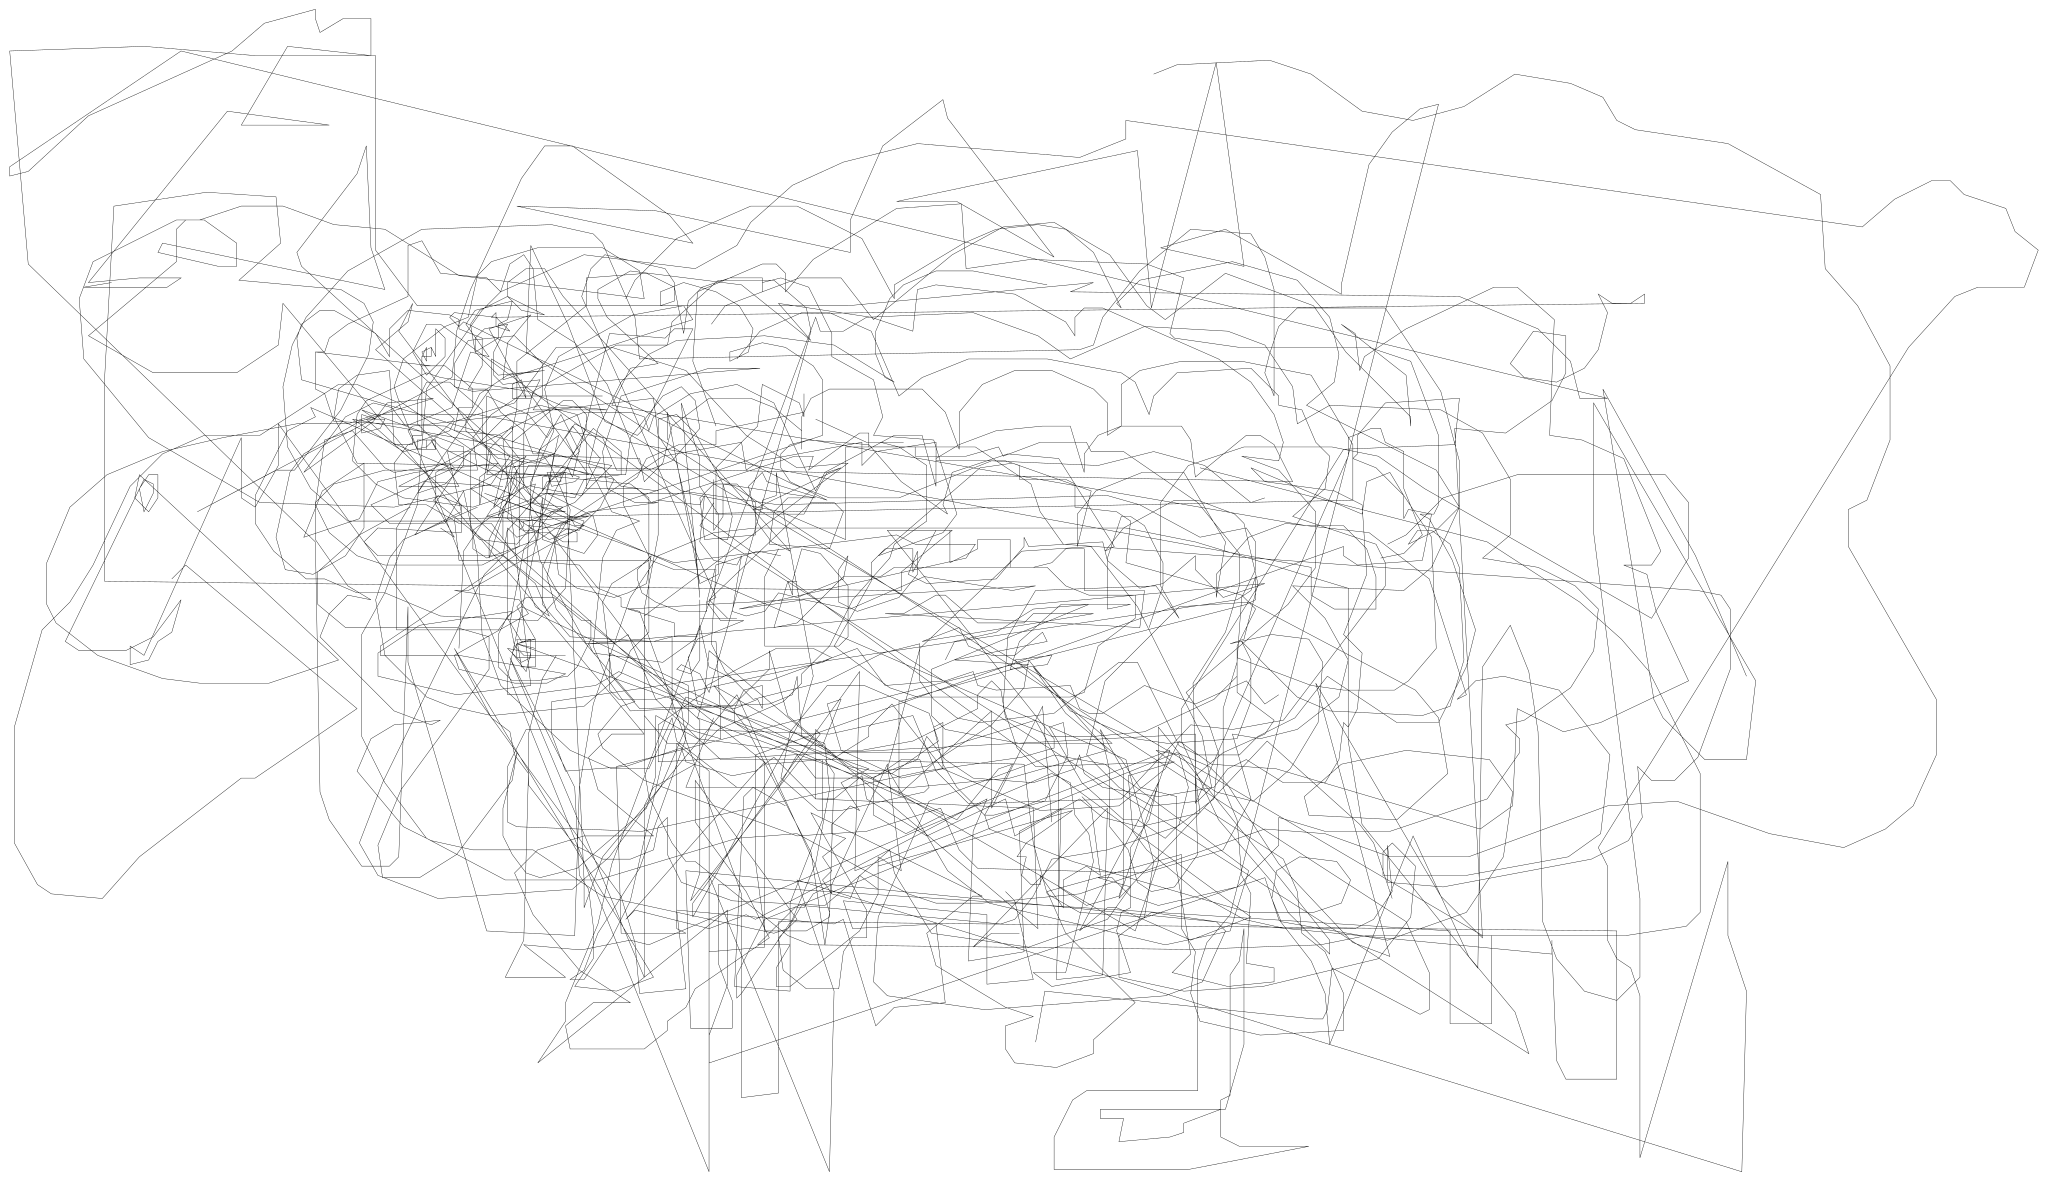

In [6]:
sk = generate_sketch_set(train_data, count=20)
ex = make_grid_svg(sk)
draw_strokes(ex)

### Pre-processing

In [0]:
def find_padding_limit(data):
    max_len = -1
    for i in range(0, data.shape[0]):
        if max_len < data[i].shape[0]:
            max_len = data[i].shape[0]

    return max_len


def pad_data(data, padding_limit):
    for i in range(0, data.shape[0]):
        data[i] = np.pad(data[i], ((0,padding_limit-data[i].shape[0]),(0,0)) ,'constant', constant_values=(0))
        

def normalize_set(data):
    data = np.array(data, dtype=np.float32)
    nor = np.amax(data, axis=(1))
    for i in range(0, data.shape[0]):
        data[i] = data[i]/nor[i]
    
    return data
        
### find padding limit
padding_limit = -1
if padding_limit < find_padding_limit(train_data): padding_limit = find_padding_limit(train_data)
if padding_limit < find_padding_limit(validation_data): padding_limit = find_padding_limit(validation_data)
if padding_limit < find_padding_limit(test_data): padding_limit = find_padding_limit(test_data)

### pad data
pad_data(train_data, padding_limit)
pad_data(validation_data, padding_limit)
pad_data(test_data, padding_limit)


### reshape data
train_data = np.vstack(train_data).reshape(-1, padding_limit, 3)
validation_data = np.vstack(validation_data).reshape(-1, padding_limit, 3)
test_data = np.vstack(test_data).reshape(-1, padding_limit, 3)
print('Train data: ', train_data.shape)
print('Validation data: ', validation_data.shape)
print('Test data: ', test_data.shape)


### normalize data
train_data = normalize_set(train_data)
validation_data = normalize_set(validation_data)
test_data = normalize_set(test_data)


## previous normalization - not good

# ### normalizing limit
# nor = []
# nor.append(np.amax(train_data, axis=(0,1)))
# nor.append(np.amax(validation_data, axis=(0,1)))
# nor.append(np.amax(test_data, axis=(0,1)))

# normalize_limit = np.amax(nor, axis=0)
# # print(normalize_limit)

# ### normalize data
# train_data = train_data/normalize_limit
# validation_data = validation_data/normalize_limit
# test_data = test_data/normalize_limit


### convert to pytorch tensor
train_data = torch.tensor(train_data)
validation_data= torch.tensor(validation_data)
test_data = torch.tensor(test_data)

Train data:  (7400, 250, 3)
Validation data:  (300, 250, 3)
Test data:  (300, 250, 3)


## Baseline
The Baseline model is removed, because that is similar to the improved model, and it was making the notebook too long. The improved model uses a similar architecture, but it uses bi-directional LSTM for the generator. 
The baseline result is attached to the report. 

## Improved GAN Model

### Model for Discriminator and Generator

In [0]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self, sequence_length, input_size, hidden_size, num_layers, output_size, dropout, device):
        super(DiscriminatorNet, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.device=device
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size*sequence_length, 256)
        
        self.fc2 = nn.Linear(256, output_size)
        

    def init_hidden(self, batch_size):
        self.h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        self.c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        
    def forward(self, x, T=1):  # T is temperature
        x, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
        x = x.contiguous().view(-1, self.hidden_size*self.sequence_length)
        x = torch.tanh(self.fc(x))
        x = self.fc2(x)
        out = torch.sigmoid(x/T)
        return out
    

In [0]:
class GeneratorNet(torch.nn.Module):
    def __init__(self, sequence_length, input_size, hidden_size, num_layers, output_size, dropout, device):
        super(GeneratorNet, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.dropout = dropout
        self.device=device
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True) 
        
        self.fc = nn.Linear(hidden_size*sequence_length*2, output_size)

    def init_hidden(self, batch_size):
        self.h0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size, device=self.device)
        self.c0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size, device=self.device)
        
    def forward(self, x, T=1):  # T is temperature
        x, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
        x = x.contiguous().view(-1, self.hidden_size*self.sequence_length*2)
        x = self.fc(x)
        out = torch.tanh(x/T)  # use temperature 
        return out


### Conversion of vectors and sketches

In [0]:
def images_to_vectors(images):
    return images.view(images.shape[0], 750)

def vectors_to_images(vectors):
    return vectors.view(vectors.shape[0], 250, 3)

### Noise generation

In [0]:
# # Noise
# def noise(size):
#     n = torch.randn(size, 750)
#     n = n.view(size, 250, 3)
#     if torch.cuda.is_available(): return n.cuda() 
#     return n

In [0]:
# Noise
def noise(size):
    p = torch.randn(size, 500)
    m = torch.randint(2, (size, 250)).float()
    n = torch.cat((p, m), dim=1)
    n = n.view(size, 250, 3)
    if torch.cuda.is_available(): return n.cuda() 
    return n

### Target generation for real and fake data

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:
# ## updated for test

# def real_data_target(size):
#     '''
#     Tensor containing ones, with shape = size
#     '''
#     data = torch.rand(size, 1)*0.1
#     if torch.cuda.is_available(): return data.cuda()
#     return data

# def fake_data_target(size):
#     '''
#     Tensor containing zeros, with shape = size
#     '''
#     data = torch.ones(size, 1) - torch.rand(size, 1)*0.1
#     if torch.cuda.is_available(): return data.cuda()
#     return data

### Traning functions for discriminators and generators

In [0]:
def train_discriminator(discriminator, optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    discriminator.init_hidden(real_data.shape[0])
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    discriminator.init_hidden(real_data.shape[0])
    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(generator, discriminator, optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    discriminator.init_hidden(fake_data.shape[0])
    generator.init_hidden(fake_data.shape[0])
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Pre-training functions for the generator

In [0]:
### Train only generator with NOISE as input with L2 loss

def batch_train_generator(Yb, batch_size, generator, criterion, optimizer):
    generator.train()
    optimizer.zero_grad()
    
    Xb = noise(batch_size)
    generator.init_hidden(Xb.shape[0])
    fake_data = generator(Xb)

    fake_data = generator(Xb)
    
    loss = criterion(fake_data, Yb)
    ls = loss.item()
    loss.backward()
    optimizer.step()
    
    return ls

def train_only_generator(data, batch_size, generator, criterion, optimizer, epochs=10):
    min_loss = np.inf
    train_losses = []
    for epoch in range(0, epochs):
        train_loss = 0.0
        # create each batch and train
        for i in range(0, data.shape[0]-batch_size, batch_size):
            real_data = torch.tensor(data[i:i+batch_size], dtype=torch.float)
            real_data = images_to_vectors(real_data)
            if torch.cuda.is_available():
              real_data = real_data.cuda()
            ls = batch_train_generator(real_data, batch_size, generator, criterion, optimizer)
            train_loss += (ls/batch_size)
        
        train_losses.append(train_loss)
        
        print('epoch: ', epoch, 'training loss: ', train_loss)
    
    torch.save(generator.state_dict(), 'generator_initial_state.pt')
    
    return train_losses

### Pretrain generator

In [0]:
### Setup to train only Generator initially from NOISE with L2 loss

epcs = 50
b_size = 32

seq_length = 250
input_feature = 3
output_size = 250*3
hidden_size = 128  # lstm units
lstm_layers = 2
dropout = 0


generator = GeneratorNet(seq_length, input_feature, hidden_size, lstm_layers, output_size, dropout, device)
if torch.cuda.is_available():
    generator.cuda()

g_opt_initial = optim.Adam(generator.parameters(), lr=0.0002)
g_criterion = nn.MSELoss()

train_losses = train_only_generator(train_data, b_size, generator, g_criterion, g_opt_initial, epochs=epcs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  0 training loss:  0.2971209979150444
epoch:  1 training loss:  0.2852349022286944
epoch:  2 training loss:  0.28511408012127504
epoch:  3 training loss:  0.2851611987571232
epoch:  4 training loss:  0.28513007884612307
epoch:  5 training loss:  0.2851444986881688
epoch:  6 training loss:  0.285092874604743
epoch:  7 training loss:  0.28502642159583047
epoch:  8 training loss:  0.2849482122110203
epoch:  9 training loss:  0.2849567076191306
epoch:  10 training loss:  0.28490090335253626
epoch:  11 training loss:  0.2848879584344104
epoch:  12 training loss:  0.28483834478538483
epoch:  13 training loss:  0.2848590880748816
epoch:  14 training loss:  0.28487162553938106
epoch:  15 training loss:  0.28488828550325707
epoch:  16 training loss:  0.28486929734935984
epoch:  17 training loss:  0.28484347224002704
epoch:  18 training loss:  0.2847855868167244
epoch:  19 training loss:  0.28472215303918347
epoch:  20 training loss:  0.2847400930477306
epoch:  21 training loss:  0.284714

### Plot pre-train loss

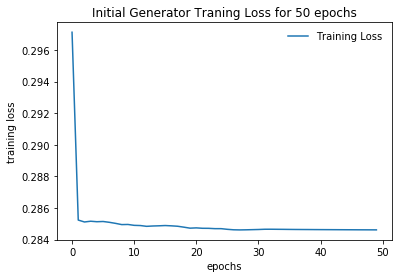

In [0]:
plot_loss(train_losses, label='Training Loss', xlabel='epochs', ylabel='training loss', title='Initial Generator Traning Loss for ' + str(epcs)+ ' epochs')

### Check the generator works after pretraining

In [0]:
generator.load_state_dict(torch.load('generator_initial_state.pt'))
fake0 = generator(noise(b_size))

i = 9
batch_size = 32
# fake0 = generator(torch.tensor(test_data[i:i+batch_size], dtype=torch.float).cuda())

fake_sheep = vectors_to_images(fake0)
fake_sheep = fake_sheep.cpu().detach().numpy()
# print(train_data[0].numpy()*normalize_limit)
# fake_sheep.shape

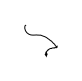

In [0]:
draw_strokes(fake_sheep[2]*30)
# fake_sheep[0]

### Generate some random noise to test GAN during training

In [0]:
num_test_samples = 32
test_noise = noise(num_test_samples)
test_noise.shape

torch.Size([32, 250, 3])

### Function to Train GAN 

In [0]:
## Modified

d_losses = []
g_losses = []


def train_GAN(discriminator, generator, data, batch_size, num_epochs):
#     d_losses = []
#     g_losses = []

    for epoch in range(num_epochs):
        d_loss = 0
        g_loss = 0
        
        run_dis = 2
        run_gen = 1
        for rd in range(run_dis):
          for i in range(0, data.shape[0]-batch_size, batch_size):
              discriminator.init_hidden(batch_size)
              generator.init_hidden(batch_size)

              # 1. Train Discriminator
              real_data = torch.tensor(data[i:i+batch_size], dtype=torch.float)
  #             real_data = images_to_vectors(real_data)
              if torch.cuda.is_available():
                real_data = real_data.cuda()

              # Generate fake data
              fake_data = vectors_to_images(generator(noise(real_data.size(0))).detach())
              # Train D
              d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator, d_optimizer, real_data, fake_data)

              d_loss += (d_error/batch_size)
            
        for rd in range(run_gen):
          for i in range(0, data.shape[0]-batch_size, batch_size):
              # 2. Train Generator
              # Generate fake data
              fake_data = vectors_to_images(generator(noise(real_data.size(0))))
              # Train G
              g_error = train_generator(generator, discriminator, g_optimizer, fake_data)

              g_loss += (g_error/batch_size)


        d_losses.append(d_loss.item()/run_dis)
        g_losses.append(g_loss.item()/run_gen)

        print('epoch: ', epoch, 'discriminator loss: \t', d_loss.item())
        print('epoch: ', epoch, 'generator loss:\t', g_loss.item())
        
        if epoch % 5 == 0:
#             print('epoch: ', epoch, 'Discriminator loss: \t', d_loss.item())
#             print('epoch: ', epoch, 'Generator loss:\t', g_loss.item())    
            torch.save(discriminator.state_dict(), 'gan_discriminator_'+str(epoch)+'.pt')
            torch.save(generator.state_dict(), 'gan_generator_'+str(epoch)+'.pt')

            test_sketches = vectors_to_images(generator(test_noise)).data.cpu().detach().numpy()
            sketches = generate_sketch_set(test_sketches, count=10)  #test_sketches.shape[0])
            grid_sketch = make_grid_svg(sketches)
            draw_strokes(grid_sketch)
    

    
    return 1, 1  # d_losses, g_losses
    

#         # Display Progress
#         if (n_batch) % 100 == 0:
#             display.clear_output(True)
#             # Display Images
#             test_images = vectors_to_images(generator(test_noise)).data.cpu()
#             logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
#             # Display status Logs
#             logger.display_status(
#                 epoch, num_epochs, n_batch, num_batches,
#                 d_error, g_error, d_pred_real, d_pred_fake
#             )


###  Train the GAN
The run was interuptted during the training as the loss was increasing
Note please, if this ipynb file is not opened in Google CoLab the svg sketches are not shown. But the screenshots of these are attached to the report.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  0 discriminator loss: 	 20.013301849365234
epoch:  0 generator loss:	 4.9991254806518555


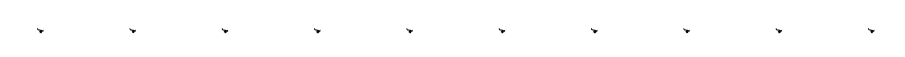

epoch:  1 discriminator loss: 	 19.907930374145508
epoch:  1 generator loss:	 0.7841302752494812
epoch:  2 discriminator loss: 	 0.2118174433708191
epoch:  2 generator loss:	 0.33289915323257446
epoch:  3 discriminator loss: 	 2.4318559169769287
epoch:  3 generator loss:	 0.28919270634651184
epoch:  4 discriminator loss: 	 5.787971496582031
epoch:  4 generator loss:	 0.13374313712120056
epoch:  5 discriminator loss: 	 1.4181859493255615
epoch:  5 generator loss:	 0.20938968658447266


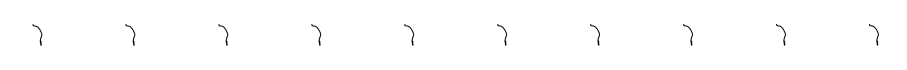

epoch:  6 discriminator loss: 	 9.476506233215332
epoch:  6 generator loss:	 0.21674276888370514
epoch:  7 discriminator loss: 	 1.2739869356155396
epoch:  7 generator loss:	 0.25319769978523254
epoch:  8 discriminator loss: 	 1.042550802230835
epoch:  8 generator loss:	 0.21183350682258606
epoch:  9 discriminator loss: 	 0.7740734815597534
epoch:  9 generator loss:	 0.2459469586610794
epoch:  10 discriminator loss: 	 3.40940523147583
epoch:  10 generator loss:	 0.21728019416332245


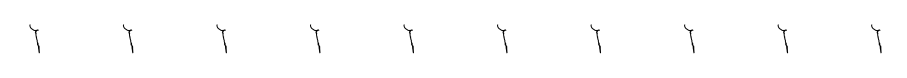

epoch:  11 discriminator loss: 	 1.9812432527542114
epoch:  11 generator loss:	 0.24319590628147125
epoch:  12 discriminator loss: 	 2.1428327560424805
epoch:  12 generator loss:	 0.22821709513664246
epoch:  13 discriminator loss: 	 1.7618452310562134
epoch:  13 generator loss:	 0.23399369418621063
epoch:  14 discriminator loss: 	 1.5524224042892456
epoch:  14 generator loss:	 0.22467699646949768
epoch:  15 discriminator loss: 	 0.9429925084114075
epoch:  15 generator loss:	 0.2950925827026367


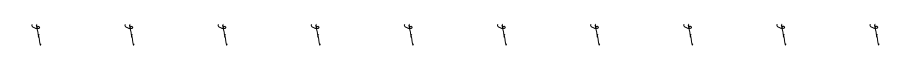

epoch:  16 discriminator loss: 	 0.44934895634651184
epoch:  16 generator loss:	 0.2587263882160187
epoch:  17 discriminator loss: 	 0.6241951584815979
epoch:  17 generator loss:	 0.256104975938797
epoch:  18 discriminator loss: 	 0.6195179224014282
epoch:  18 generator loss:	 0.24730712175369263
epoch:  19 discriminator loss: 	 2.4348928928375244
epoch:  19 generator loss:	 0.23331959545612335
epoch:  20 discriminator loss: 	 0.5129213333129883
epoch:  20 generator loss:	 0.26560327410697937


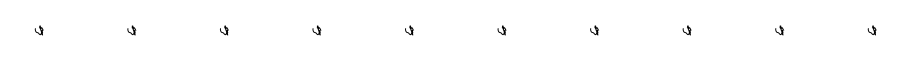

epoch:  21 discriminator loss: 	 0.9178337454795837
epoch:  21 generator loss:	 0.27440375089645386


KeyboardInterrupt: ignored

In [0]:
g_seq_length = 250
g_input_feature = 3
g_output_size = 250*3
g_hidden_size = 128  # lstm units
g_lstm_layers = 2
g_dropout = 0.2

d_seq_length = 250
d_input_feature = 3
d_output_size = 1
d_hidden_size = 256  # lstm units
d_lstm_layers = 2
d_dropout = 0.2

generator = GeneratorNet(g_seq_length, g_input_feature, g_hidden_size, g_lstm_layers, g_output_size, g_dropout, device)
discriminator = DiscriminatorNet(d_seq_length, d_input_feature, d_hidden_size, d_lstm_layers, d_output_size, d_dropout, device)

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

    
# Optimizers
d_optimizer = optim.SGD(discriminator.parameters(), lr=0.1)
g_optimizer = optim.SGD(generator.parameters(), lr=0.1)

# Loss function
loss = nn.BCELoss()
num_epochs = 100
batch_size = 32


generator.load_state_dict(torch.load('generator_initial_state.pt'))

# d_losses, g_losses = train_GAN(discriminator, generator, train_data, batch_size, num_epochs)
d_l, g_l = train_GAN(discriminator, generator, train_data, batch_size, num_epochs)

### Plot GAN loss curves

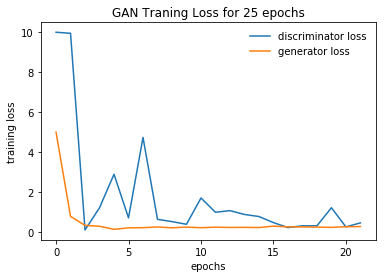

In [0]:
num_epochs = 25
plot_multiple_loss([d_losses, g_losses], labels=['discriminator loss', 'generator loss'], xlabel='epochs', ylabel='training loss', title='GAN Traning Loss for ' + str(num_epochs)+ ' epochs')

## Fully Connected GAN Model

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 750
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 750
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [0]:
def images_to_vectors(images):
    return images.view(images.shape[0], 750)

def vectors_to_images(vectors):
    return vectors.view(vectors.shape[0], 250, 3)

In [0]:
# Noise
def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [0]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
### Train only generator with NOISE as input with L2 loss

def batch_train_generator(Yb, batch_size, generator, criterion, optimizer):
    generator.train()
    optimizer.zero_grad()
    fake_data = generator(noise(batch_size))
    
    loss = criterion(fake_data, Yb)
    ls = loss.item()
    loss.backward()
    optimizer.step()
    
    return ls

def train_only_generator(data, batch_size, generator, criterion, optimizer, epochs=10):
    min_loss = np.inf
    train_losses = []
    for epoch in range(0, epochs):
        train_loss = 0.0
        # create each batch and train
        for i in range(0, data.shape[0]-batch_size, batch_size):
            real_data = torch.tensor(data[i:i+batch_size], dtype=torch.float)
            real_data = images_to_vectors(real_data)
            if torch.cuda.is_available():
              real_data = real_data.cuda()
            ls = batch_train_generator(real_data, batch_size, generator, criterion, optimizer)
            train_loss += (ls/batch_size)
        
        train_losses.append(train_loss)
        
        print('epoch: ', epoch, 'training loss: ', train_loss)
    
    torch.save(generator.state_dict(), 'generator_initial_state.pt')
    
    return train_losses

In [0]:
### Setup to train only Generator initially from NOISE with L2 loss

epcs = 100
b_size = 32

g_opt_initial = optim.Adam(generator.parameters(), lr=0.000001)
g_criterion = nn.MSELoss()

train_losses = train_only_generator(train_data, b_size, generator, g_criterion, g_opt_initial, epochs=epcs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  0 training loss:  0.3051430870546028
epoch:  1 training loss:  0.30123585218098015
epoch:  2 training loss:  0.2985861550550908
epoch:  3 training loss:  0.2964783009956591
epoch:  4 training loss:  0.29500717588234693
epoch:  5 training loss:  0.2938581939670257
epoch:  6 training loss:  0.2929895821143873
epoch:  7 training loss:  0.2922654888825491
epoch:  8 training loss:  0.2916812315233983
epoch:  9 training loss:  0.2912155733210966
epoch:  10 training loss:  0.29083760955836624
epoch:  11 training loss:  0.2905354153481312
epoch:  12 training loss:  0.29024768964154646
epoch:  13 training loss:  0.2900851078447886
epoch:  14 training loss:  0.28980024525662884
epoch:  15 training loss:  0.2897186916670762
epoch:  16 training loss:  0.28952982620103285
epoch:  17 training loss:  0.2894157696282491
epoch:  18 training loss:  0.2892789565376006
epoch:  19 training loss:  0.2891684854403138
epoch:  20 training loss:  0.2890815085847862
epoch:  21 training loss:  0.288941654

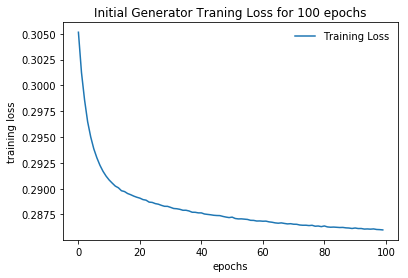

In [0]:
plot_loss(train_losses, label='Training Loss', xlabel='epochs', ylabel='training loss', title='Initial Generator Traning Loss for ' + str(epcs)+ ' epochs')

In [0]:
fake0 = generator(noise(b_size))
fake_sheep = vectors_to_images(fake0)
fake_sheep = fake_sheep.cpu().detach().numpy()
# print(train_data[0].numpy()*normalize_limit)
# fake_sheep.shape

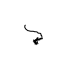

In [0]:
draw_strokes(fake_sheep[10]*20)

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)
test_noise.shape

torch.Size([16, 100])

In [0]:
def train_GAN(data, batch_size, num_epochs):
    d_losses = []
    g_losses = []

    for epoch in range(num_epochs):
        d_loss = 0
        g_loss = 0

        for i in range(0, data.shape[0]-batch_size, batch_size):
            # 1. Train Discriminator
            real_data = torch.tensor(data[i:i+batch_size], dtype=torch.float)
            real_data = images_to_vectors(real_data)
            if torch.cuda.is_available():
              real_data = real_data.cuda()

            # Generate fake data
            fake_data = generator(noise(real_data.size(0))).detach()
            # Train D
            d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

            # 2. Train Generator
            # Generate fake data
            fake_data = generator(noise(real_data.size(0)))
            # Train G
            g_error = train_generator(g_optimizer, fake_data)

            d_loss += (d_error/batch_size)
            g_loss += (g_error/batch_size)


        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

#         print('epoch: ', epoch, 'discriminator loss: \t', d_loss.item())
#         print('epoch: ', epoch, 'generator loss:\t', g_loss.item())
        
        if epoch % 25 == 0:
            print('epoch: ', epoch, 'Discriminator loss: \t', d_loss.item())
            print('epoch: ', epoch, 'Generator loss:\t', g_loss.item())    
            torch.save(discriminator.state_dict(), 'gan_discriminator_'+str(epoch)+'.pt')
            torch.save(generator.state_dict(), 'gan_generator_'+str(epoch)+'.pt')

            test_sketches = vectors_to_images(generator(test_noise)).data.cpu().detach().numpy()
            sketches = generate_sketch_set(test_sketches, count=test_sketches.shape[0])
            grid_sketch = make_grid_svg(sketches)
            draw_strokes(grid_sketch)
    

    
    return d_losses, g_losses
    

#         # Display Progress
#         if (n_batch) % 100 == 0:
#             display.clear_output(True)
#             # Display Images
#             test_images = vectors_to_images(generator(test_noise)).data.cpu()
#             logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
#             # Display status Logs
#             logger.display_status(
#                 epoch, num_epochs, n_batch, num_batches,
#                 d_error, g_error, d_pred_real, d_pred_fake
#             )


In [0]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    
generator.load_state_dict(torch.load('generator_initial_state.pt'))

In [0]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


epoch:  0 Discriminator loss: 	 10.804183006286621
epoch:  0 Generator loss:	 7.674229621887207


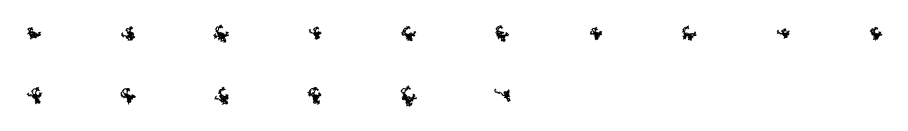

epoch:  25 Discriminator loss: 	 4.718467712402344
epoch:  25 Generator loss:	 27.959787368774414


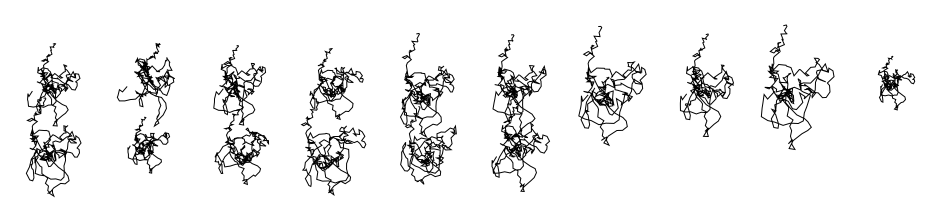

epoch:  50 Discriminator loss: 	 6.6524553298950195
epoch:  50 Generator loss:	 20.176132202148438


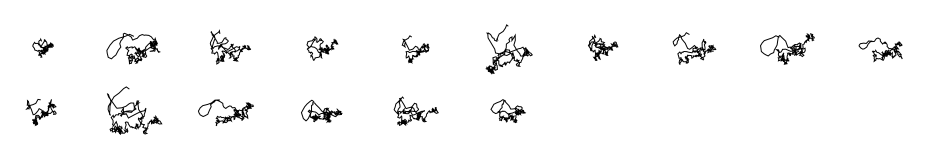

epoch:  75 Discriminator loss: 	 9.335794448852539
epoch:  75 Generator loss:	 16.540067672729492


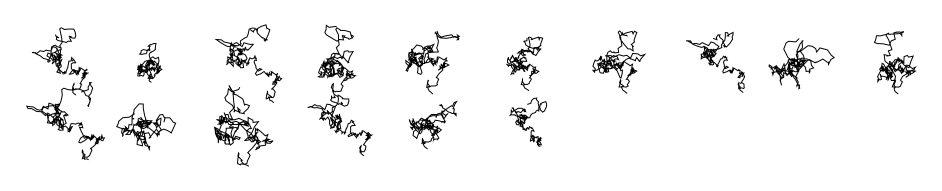

epoch:  100 Discriminator loss: 	 6.988105773925781
epoch:  100 Generator loss:	 9.889561653137207


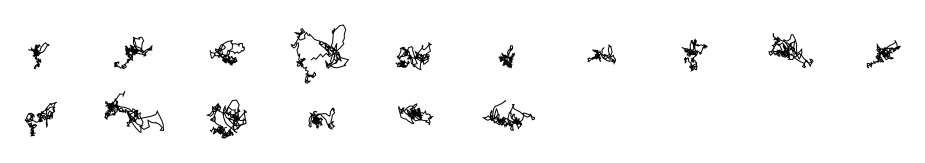

epoch:  125 Discriminator loss: 	 7.066817760467529
epoch:  125 Generator loss:	 9.76761531829834


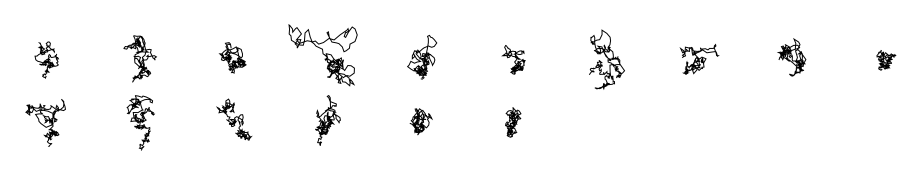

epoch:  150 Discriminator loss: 	 8.19923210144043
epoch:  150 Generator loss:	 11.769742965698242


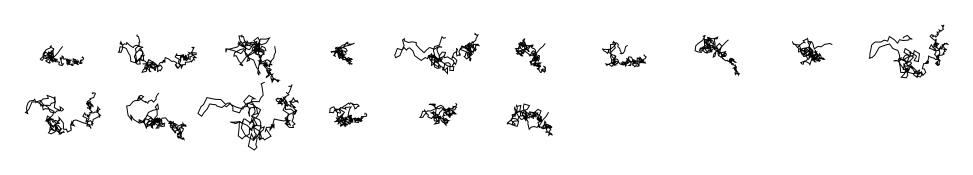

epoch:  175 Discriminator loss: 	 6.390974044799805
epoch:  175 Generator loss:	 13.442482948303223


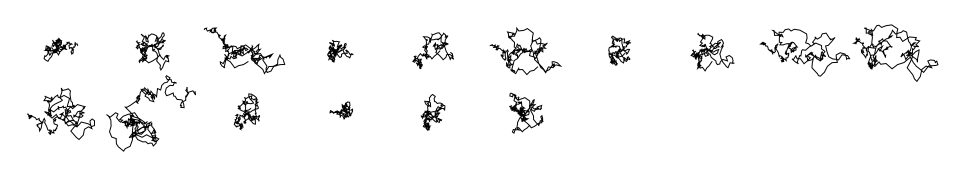

In [0]:
batch_size = 32
num_epochs = 200

d_losses, g_losses = train_GAN(train_data, batch_size, num_epochs)

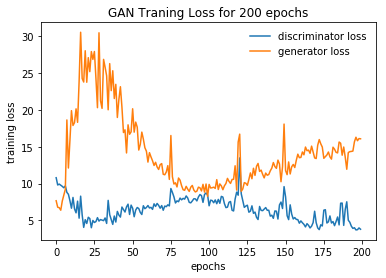

In [0]:
plot_multiple_loss([d_losses, g_losses], labels=['discriminator loss', 'generator loss'], xlabel='epochs', ylabel='training loss', title='GAN Traning Loss for ' + str(num_epochs)+ ' epochs')